In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df=pd.read_csv('precios_mundiales_petroleo.csv', delimiter=";")
df = df.replace(',',"")
df['World Share'] = df['World Share'].str.rstrip('%').astype(float)

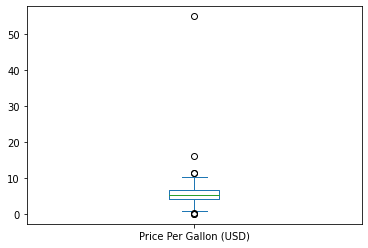

In [3]:
aux = df[["Price Per Gallon (USD)"]]
aux.astype(float).plot(kind="box")

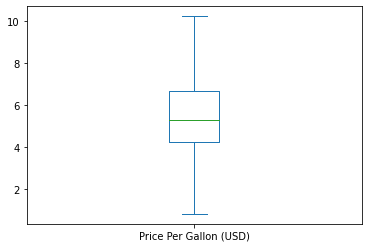

In [4]:
def outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final = df[(df <= Q3+1.5*IQR) & (df >= Q1-1.5*IQR)]
    return df_final

nuevo_aux = outlier_IQR(aux)
nuevo_aux = pd.DataFrame(nuevo_aux)
ind_dif = aux.index.difference(nuevo_aux.index)

for i in range(len(ind_dif)):
  df2 = aux.drop([ind_dif[i]])
  nuevo_aux = df2

nuevo_aux.astype(float).plot(kind="box")

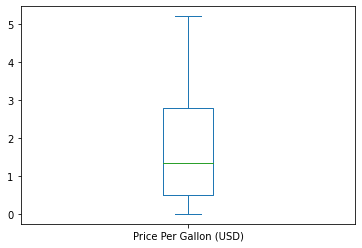

In [6]:
def outlier_Hampel(df):
    med=df.median()
    List=abs(df-med)
    cond=List.median()*4.5
    df_final=List[~(List>cond)]
    return df_final

nuevo_aux = outlier_Hampel(aux)
nuevo_aux = pd.DataFrame(nuevo_aux)
ind_dif = aux.index.difference(nuevo_aux.index)

for i in range(len(ind_dif)):
  df2 = aux.drop([ind_dif[i]])
  nuevo_aux = df2
  
nuevo_aux.astype(float).plot(kind="box")

In [26]:
from tqdm import tqdm_notebook as tqdm

a = np.arange(0, aux.shape[1])
dfaumentado = pd.DataFrame(index=aux.index, columns=aux.columns, dtype='float64')

for i in tqdm(range(0, len(aux))):
    razon = 0.5
    cuenta = np.floor(aux.shape[1]*razon).astype('int16')
    
    indices_aumentados = np.random.choice(aux.shape[1], cuenta, replace=False)
    indices_aumentados.sort()
    
    indices = np.where(np.logical_not(np.in1d(a, indices_aumentados)))[0]
        
    dfaumentado.iloc[i, indices] = df.iloc[i, indices]
    indicesaleatorios = np.random.choice(len(aux), len(indices_aumentados), replace=True)
        
    for n, j in enumerate(indices_aumentados):
        dfaumentado.iloc[i, j] = aux.iloc[indicesaleatorios[n], j]

print(dfaumentado)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/181 [00:00<?, ?it/s]

     Price Per Gallon (USD)
0                       1.0
1                       2.0
2                       3.0
3                       4.0
4                       5.0
..                      ...
176                   177.0
177                   178.0
178                   179.0
179                   180.0
180                   181.0

[181 rows x 1 columns]


In [ ]:
# ejemplo para generar imágenes con GAN

!pip -q install imageio
!pip -q install scikit-image
!pip install -q git+https://github.com/tensorflow/docs

from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time
from skimage.transform import resize

from google.colab import files

from IPython import display
from skimage import transform

latent_dim = 512

def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

In [ ]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']
def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

target_image = upload_image()
display_image(target_image)

In [ ]:
tf.random.set_seed(4321)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [ ]:
def find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)  
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      loss = loss_fn(image, target_image[:,:,:3])
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))

  return images, losses


num_optimization_steps=10000
steps_per_image=100
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


In [ ]:
animate(np.stack(images))

In [ ]:
plt.plot(loss)
plt.xlabel("Epoca")
plt.ylabel("Costo")
plt.grid(True)
plt.ylim([0,max(plt.ylim())])
plt.show()

display_image(np.concatenate([images[-1], target_image], axis=1))